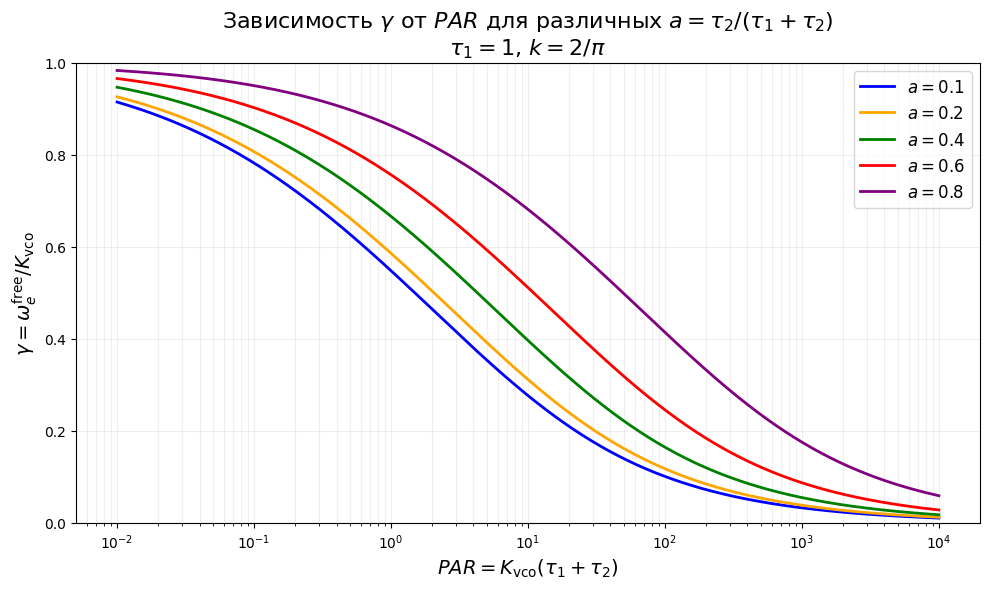

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Фиксированные параметры из задачи
tau1 = 1.0
k = 2.0 / np.pi

# Значения параметра a = tau2 / (tau1 + tau2)
a_vals = [0.1, 0.2, 0.4, 0.6, 0.8]
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Сетка для PAR = K_vco * (tau1 + tau2)
PAR_log = np.logspace(-2, 4, 1000)  # от 10^-2 до 10^4

# Создаем график
plt.figure(figsize=(10, 6))

for idx, a in enumerate(a_vals):
    # Вычисляем tau2 из a
    tau2 = a * tau1 / (1 - a)
    gamma_vals = []

    # Для каждого значения PAR вычисляем K_vco
    for PAR in PAR_log:
        K_vco = PAR / (tau1 + tau2)

        # Вычисляем коэффициенты уравнения (моя версия)
        tau1_plus_2tau2 = tau1 + 2*tau2

        # Коэффициенты полинома 4-й степени: a4*γ^4 + a3*γ^3 + a2*γ^2 + a1*γ + a0 = 0
        a4 = 4*K_vco*k*tau1**2 + 4*tau1_plus_2tau2 - k*np.pi*tau1_plus_2tau2
        a3 = -8*tau1_plus_2tau2
        a2 = 4*K_vco*k*tau1**2 + 4*tau1_plus_2tau2 + 2*k*np.pi*tau1_plus_2tau2
        a1 = 0.0
        a0 = -k*np.pi*tau1_plus_2tau2

        coeffs = [a4, a3, a2, a1, a0]

        # Находим корни полинома
        roots = np.roots(coeffs)
        # Выбираем только действительные корни в интервале [0, 1]
        real_roots = roots[np.isreal(roots)].real
        valid_roots = [r for r in real_roots if 0 <= r <= 1]

        if valid_roots:
            # Для последовательности выбираем корень с наибольшей гладкостью
            # (обычно это наибольший корень, т.к. γ должен расти с ростом PAR)
            gamma_vals.append(max(valid_roots))
        else:
            gamma_vals.append(np.nan)

    # Построение кривой для данного a
    plt.plot(PAR_log, gamma_vals, color=colors[idx], label=f'$a = {a}$', linewidth=2)

# Настройка графика
plt.xscale('log')
plt.xlabel('$PAR = K_{\\text{vco}} (\\tau_1 + \\tau_2)$', fontsize=14)
plt.ylabel('$\\gamma = \\omega_e^{\\text{free}} / K_{\\text{vco}}$', fontsize=14)
plt.title('Зависимость $\\gamma$ от $PAR$ для различных $a = \\tau_2/(\\tau_1+\\tau_2)$\n$\\tau_1=1$, $k=2/\\pi$', fontsize=16)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(fontsize=12)
plt.ylim(0, 1)

# Добавим асимптотическую линию при γ=1
plt.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='$\\gamma = 1$')

# Отображение графика
plt.tight_layout()
plt.show()

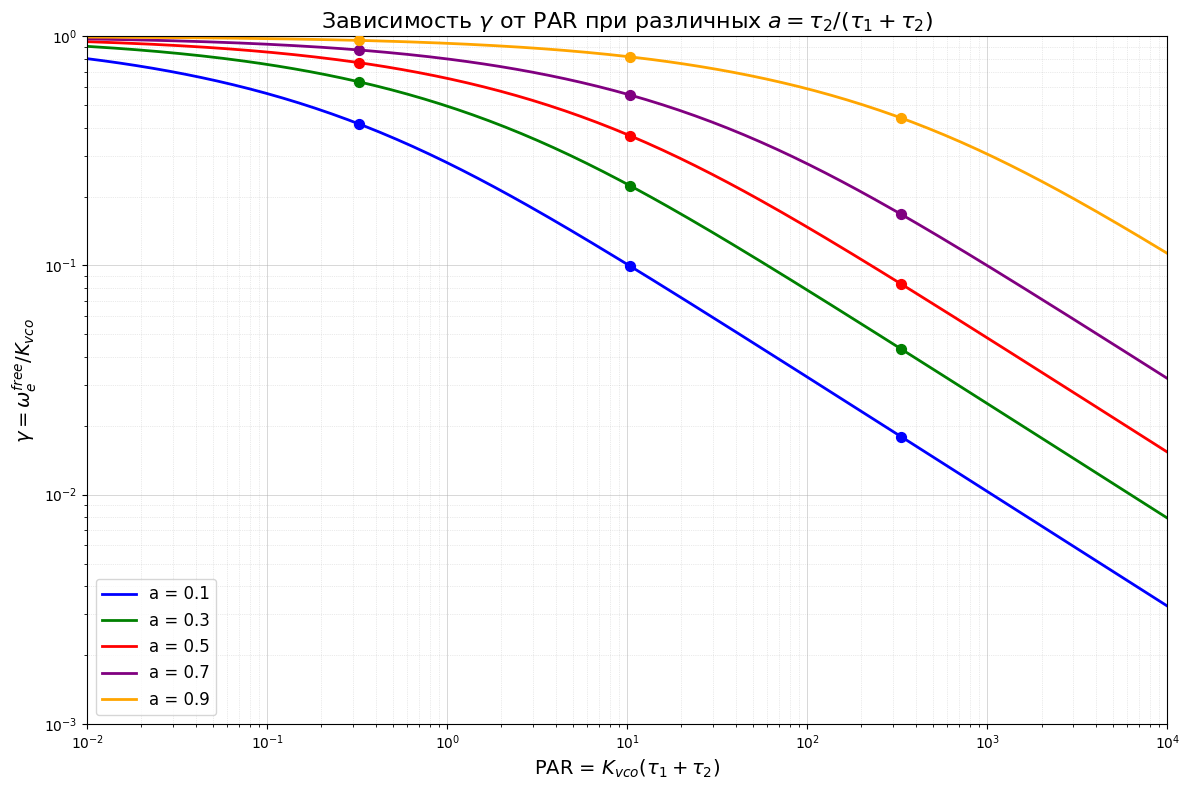

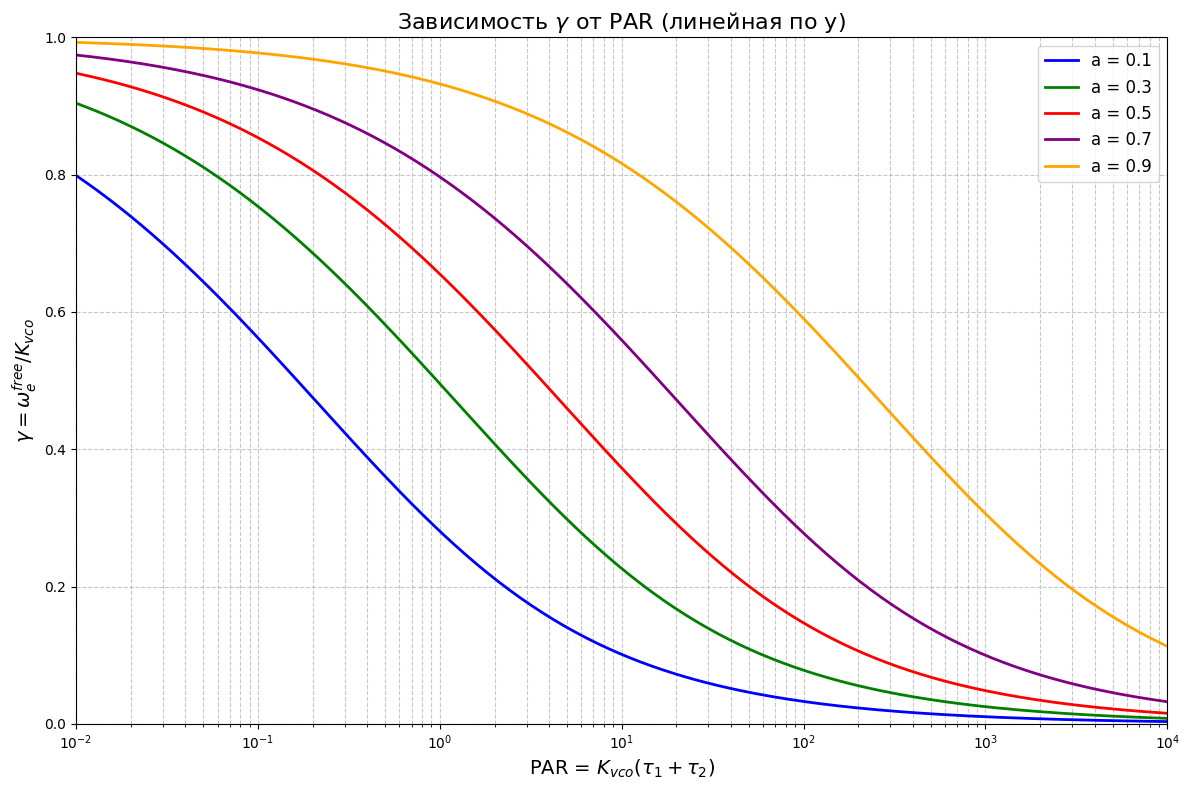

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

def equation_for_gamma(gamma, a, PAR, tau1_tau2_ratio):
    """
    Уравнение для нахождения gamma:
    a4*gamma^4 + a3*gamma^3 + a2*gamma^2 + a0 = 0

    Параметры:
    gamma - искомая величина
    a = tau2/(tau1+tau2)
    PAR = K_vco*(tau1+tau2)
    tau1_tau2_ratio = tau1/tau2

    Возвращает значение уравнения (должно быть 0)
    """

    tau1_tau2 = tau1_tau2_ratio
    a_coeff = a
    tau2 = 1.0
    tau1 = (1/a - 1) * tau2
    term1 = 2*tau1**2/tau2
    term2 = 2*(tau1 + 2*tau2)/(tau2 * PAR)
    term3 = np.pi*(tau1 + 2*tau2)/(2*tau2 * PAR)

    a4 = term1 + term2 - term3
    a3 = -4*(tau1 + 2*tau2)/(tau2 * PAR)
    a2 = term1 + term2 + 2*term3
    a0 = -term3

    return a4*gamma**4 + a3*gamma**3 + a2*gamma**2 + a0

def find_gamma_for_PAR(PAR, a):
    """
    Находит gamma для заданных PAR и a
    """

    tau1_tau2_ratio = 1/a - 1


    initial_guess = 0.5

    try:

        gamma_solution = fsolve(
            lambda g: equation_for_gamma(g, a, PAR, tau1_tau2_ratio),
            initial_guess
        )[0]


        gamma_solution = max(0, min(1, gamma_solution))

        return gamma_solution
    except:
        return np.nan

# Параметры для графиков
PAR_values = np.logspace(-2, 4, 200)  # от 10^-2 до 10^4

# Разные значения a = tau2/(tau1+tau2)
a_values = [0.1, 0.3, 0.5, 0.7, 0.9]
colors = ['blue', 'green', 'red', 'purple', 'orange']
labels = [f'a = {a}' for a in a_values]

# Создаем график
plt.figure(figsize=(12, 8))

# Для каждого значения a строим кривую
for a, color, label in zip(a_values, colors, labels):
    gamma_values = []

    for PAR in PAR_values:
        gamma = find_gamma_for_PAR(PAR, a)
        gamma_values.append(gamma)

    # Строим график
    plt.loglog(PAR_values, gamma_values, color=color, linewidth=2, label=label)

    # Добавляем точки для некоторых значений
    sample_indices = [50, 100, 150]
    for idx in sample_indices:
        plt.scatter(PAR_values[idx], gamma_values[idx], color=color, s=50, zorder=5)

# Настройки графика
plt.xlabel('PAR = $K_{vco}(\\tau_1 + \\tau_2)$', fontsize=14)
plt.ylabel('$\\gamma = \\omega_e^{free}/K_{vco}$', fontsize=14)
plt.title('Зависимость $\\gamma$ от PAR при различных $a = \\tau_2/(\\tau_1+\\tau_2)$', fontsize=16)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xlim(1e-2, 1e4)
plt.ylim(1e-3, 1)

# Добавляем сетку
plt.grid(True, which='major', linestyle='-', linewidth=0.5, alpha=0.7)
plt.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()

# Также построим график в линейных координатах для наглядности
plt.figure(figsize=(12, 8))

for a, color, label in zip(a_values, colors, labels):
    gamma_values = []

    for PAR in PAR_values:
        gamma = find_gamma_for_PAR(PAR, a)
        gamma_values.append(gamma)

    # Строим график в линейных координатах по x (логарифмическая шкала для PAR)
    plt.semilogx(PAR_values, gamma_values, color=color, linewidth=2, label=label)

plt.xlabel('PAR = $K_{vco}(\\tau_1 + \\tau_2)$', fontsize=14)
plt.ylabel('$\\gamma = \\omega_e^{free}/K_{vco}$', fontsize=14)
plt.title('Зависимость $\\gamma$ от PAR (линейная по y)', fontsize=16)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.xlim(1e-2, 1e4)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()



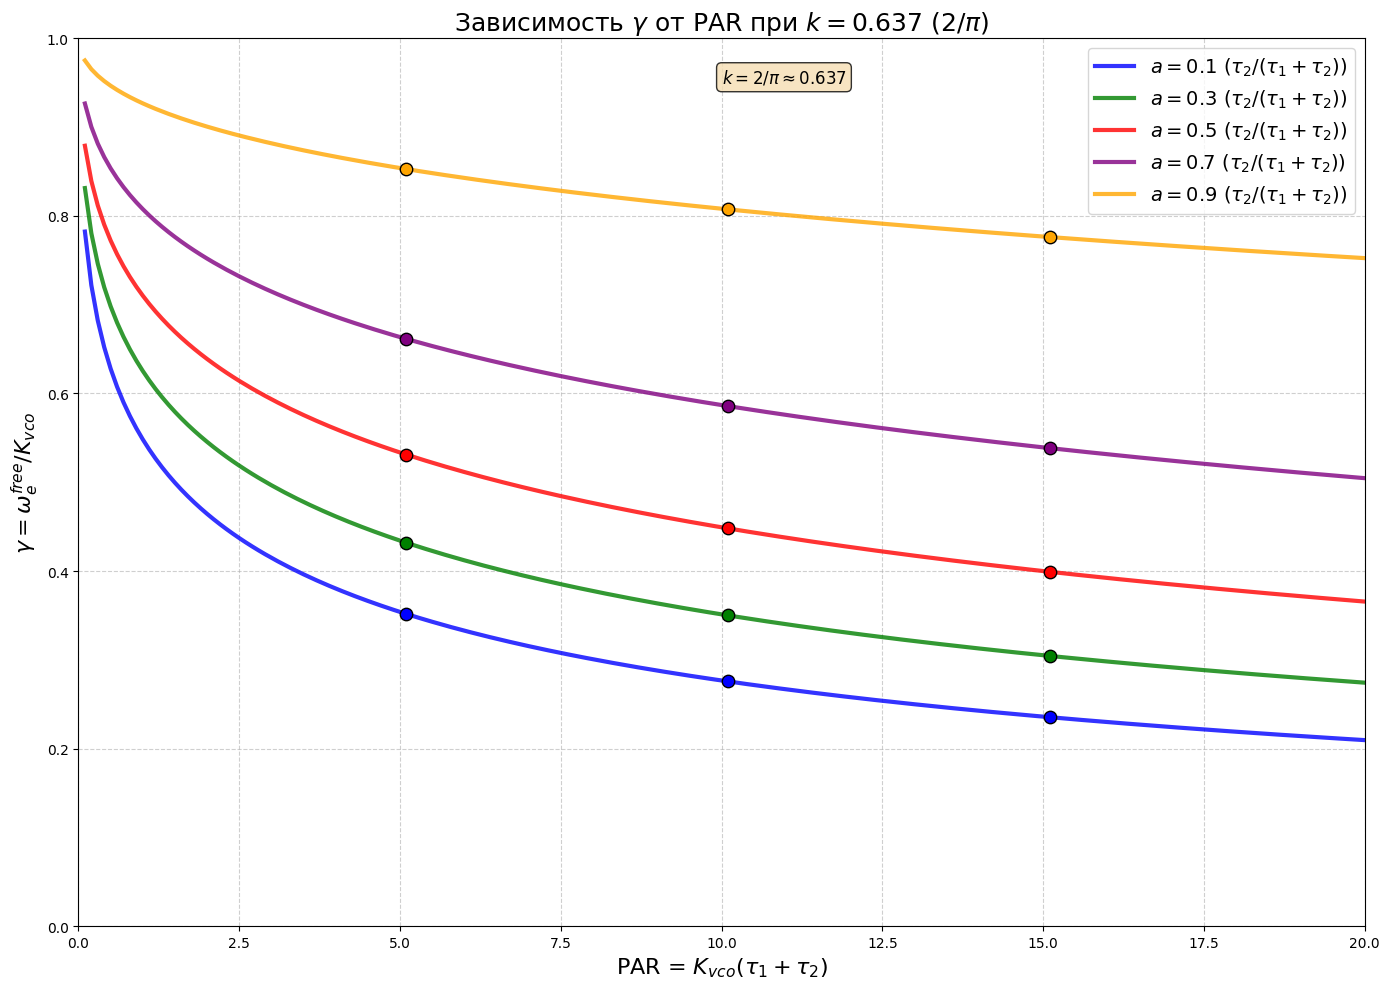

k = 0.6366 (2/π)

Значения γ для различных a и PAR:
------------------------------------------------------------
PAR      a=0.1      a=0.3      a=0.5      a=0.7      a=0.9     
------------------------------------------------------------
0.5      0.6279     0.6981     0.7723     0.8535     0.9466    
1        0.5482     0.6253     0.7101     0.8076     0.9268    
2        0.4644     0.5455     0.6388     0.7519     0.9005    
5        0.3539     0.4342     0.5335     0.6635     0.8539    
10       0.2767     0.3512     0.4492     0.5869     0.8081    
15       0.2360     0.3051     0.3999     0.5392     0.7767    
20       0.2095     0.2742     0.3656     0.5046     0.7524    
------------------------------------------------------------


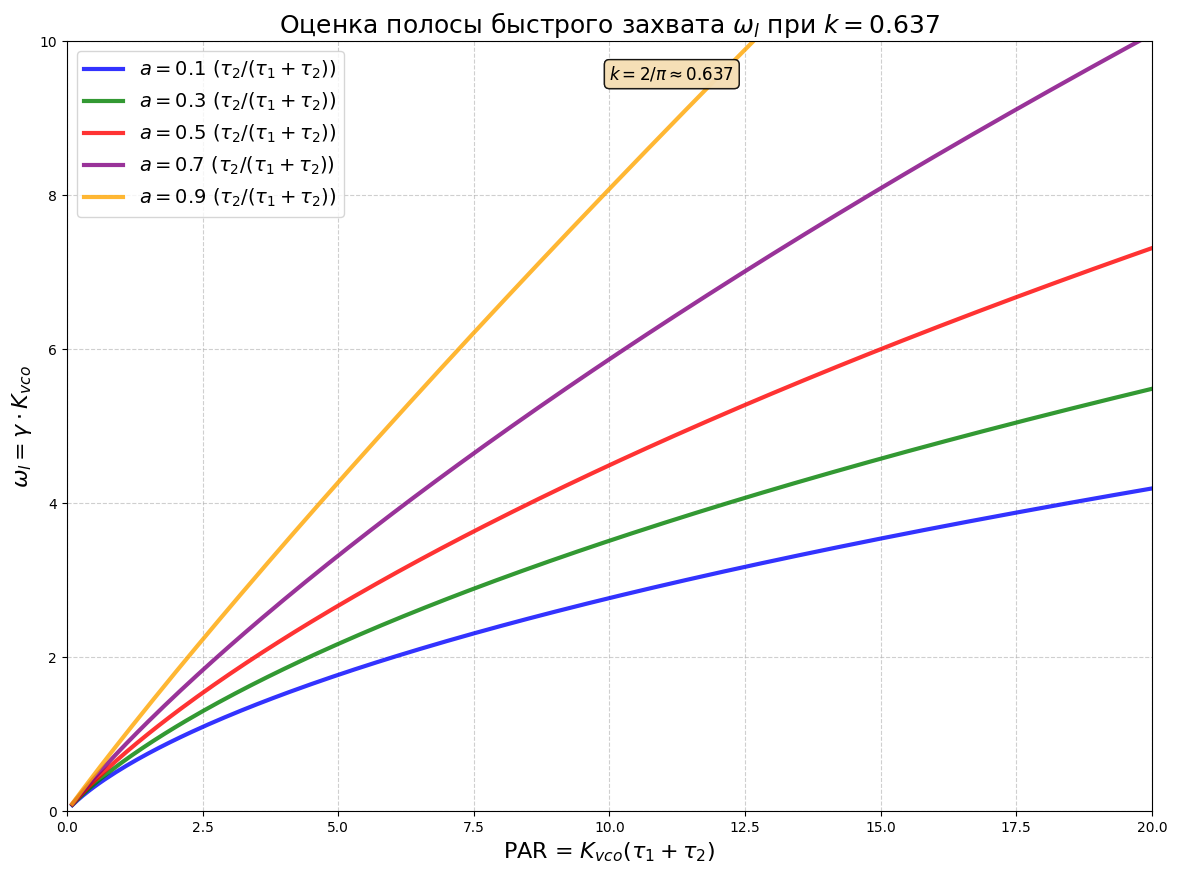

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve, brentq

# Заданное значение k
k = 2.0 / np.pi

def equation_for_gamma(gamma, a, PAR):
    """
    Уравнение для нахождения gamma:
    a4*gamma^4 + a3*gamma^3 + a2*gamma^2 + a0 = 0

    Параметры:
    gamma - искомая величина
    a = tau2/(tau1+tau2)
    PAR = K_vco*(tau1+tau2)
    k = 2/pi (задано)

    Возвращает значение уравнения (должно быть 0)
    """
    # Используем соотношения:
    # a = tau2/(tau1+tau2)
    # Пусть tau1+tau2 = T, тогда tau2 = a*T, tau1 = T - tau2 = T(1-a)
    # Для упрощения положим T = tau1+tau2 = 1 (масштабная инвариантность)
    T = 1.0  # tau1+tau2 = 1
    tau2 = a * T  # так как a = tau2/(tau1+tau2)
    tau1 = 1 - a

    # K_vco из PAR: PAR = K_vco * (tau1+tau2) = K_vco * T
    K_vco = PAR / T

    # Вычисляем коэффициенты уравнения с учетом k = 2/pi
    # Общие множители
    common_factor = (tau1 + 2*tau2) / (tau2 * K_vco)

    # Коэффициенты уравнения
    a4 = 2*tau1**2/tau2 + 2*common_factor/k - (np.pi/2)*common_factor
    a3 = -4*common_factor/k
    a2 = 2*tau1**2/tau2 + 2*common_factor/k + np.pi*common_factor
    a0 = -(np.pi/2)*common_factor

    # Уравнение: a4*gamma^4 + a3*gamma^3 + a2*gamma^2 + a0 = 0
    return a4*gamma**4 + a3*gamma**3 + a2*gamma**2 + a0

def find_gamma_for_PAR(PAR, a):
    """
    Находит gamma для заданных PAR и a
    """
    try:
        # Ищем корень уравнения в диапазоне [0, 1]
        # Используем метод Брента, так как он более надежен
        def f(gamma):
            return equation_for_gamma(gamma, a, PAR)

        # Проверяем значения на границах
        f0 = f(0)
        f1 = f(1)

        # Если знаки разные на границах, ищем корень
        if f0 * f1 <= 0:
            try:
                gamma_solution = brentq(f, 0, 1, xtol=1e-12, rtol=1e-12)
                return gamma_solution
            except:
                pass

        # Если не нашли корень методом Брента, пробуем сканирование
        gamma_test = np.linspace(0, 1, 1001)
        eq_values = f(gamma_test)

        # Ищем переход через ноль
        zero_crossings = np.where(np.diff(np.sign(eq_values)))[0]

        if len(zero_crossings) > 0:
            # Берем первый переход через ноль
            idx = zero_crossings[0]
            # Линейная интерполяция для более точного значения
            x1, x2 = gamma_test[idx], gamma_test[idx+1]
            y1, y2 = eq_values[idx], eq_values[idx+1]
            if y1 != y2:
                gamma_solution = x1 - y1 * (x2 - x1) / (y2 - y1)
                return max(0, min(1, gamma_solution))

        return np.nan
    except:
        return np.nan

# Параметры для графиков - линейная сетка
PAR_values = np.linspace(0.1, 20, 200)  # от 0.1 до 20

# Разные значения a = tau2/(tau1+tau2)
a_values = [0.1, 0.3, 0.5, 0.7, 0.9]
colors = ['blue', 'green', 'red', 'purple', 'orange']
labels = [f'$a = {a}$ ($\\tau_2/(\\tau_1+\\tau_2)$)' for a in a_values]

# Создаем график зависимости gamma от PAR
plt.figure(figsize=(14, 10))

# Для каждого значения a строим кривую
for a, color, label in zip(a_values, colors, labels):
    gamma_values = []

    for PAR in PAR_values:
        gamma = find_gamma_for_PAR(PAR, a)
        gamma_values.append(gamma)

    # Строим график
    plt.plot(PAR_values, gamma_values, color=color, linewidth=3, label=label, alpha=0.8)

    # Добавляем маркеры для некоторых значений
    sample_indices = [50, 100, 150]
    for idx in sample_indices:
        if idx < len(PAR_values) and not np.isnan(gamma_values[idx]):
            plt.scatter(PAR_values[idx], gamma_values[idx], color=color, s=80,
                       edgecolor='black', linewidth=1, zorder=5)

# Настройки графика
plt.xlabel('PAR = $K_{vco}(\\tau_1 + \\tau_2)$', fontsize=16)
plt.ylabel('$\\gamma = \\omega_e^{free}/K_{vco}$', fontsize=16)
plt.title(f'Зависимость $\\gamma$ от PAR при $k = {k:.3f}$ ($2/\\pi$)', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14, loc='upper right')
plt.xlim(0, 20)
plt.ylim(0, 1)


# Добавляем информацию о k
plt.text(0.5, 0.95, f'$k = 2/\\pi \\approx {k:.3f}$',
         fontsize=12, transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

# График: зависимость omega_l от PAR (оценка полосы быстрого захвата)
plt.figure(figsize=(14, 10))

for a, color, label in zip(a_values, colors, labels):
    gamma_values = []
    omega_l_values = []
    valid_PAR = []

    for PAR in PAR_values:
        gamma = find_gamma_for_PAR(PAR, a)
        if not np.isnan(gamma):
            gamma_values.append(gamma)
            # omega_l = gamma * K_vco
            # При (tau1+tau2)=1, K_vco = PAR
            omega_l = gamma * PAR
            omega_l_values.append(omega_l)
            valid_PAR.append(PAR)

    # Строим график omega_l
    if omega_l_values:
        plt.plot(valid_PAR, omega_l_values, color=color,
                linewidth=3, label=f'{label}', alpha=0.8)

plt.xlabel('PAR = $K_{vco}(\\tau_1 + \\tau_2)$', fontsize=16)
plt.ylabel('$\\omega_l = \\gamma \\cdot K_{vco}$', fontsize=16)
plt.title(f'Оценка полосы быстрого захвата $\\omega_l$ при $k = {k:.3f}$', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=14, loc='upper left')
plt.xlim(0, 20)
plt.ylim(0, 10)

# Добавляем информацию о k
plt.text(0.5, 0.95, f'$k = 2/\\pi \\approx {k:.3f}$',
         fontsize=12, transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))



# Добавляем информацию о k
plt.text(0.5, 0.95, f'$k = 2/\\pi \\approx {k:.3f}$',
         fontsize=12, transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))



# Сводная таблица значений для некоторых точек
print(f"k = {k:.4f} (2/π)")
print("\nЗначения γ для различных a и PAR:")
print("-" * 60)
print(f"{'PAR':<8} {'a=0.1':<10} {'a=0.3':<10} {'a=0.5':<10} {'a=0.7':<10} {'a=0.9':<10}")
print("-" * 60)

for PAR in [0.5, 1, 2, 5, 10, 15, 20]:
    row_values = [PAR]
    for a in a_values:
        gamma = find_gamma_for_PAR(PAR, a)
        row_values.append(f"{gamma:.4f}" if not np.isnan(gamma) else "nan")
    print(f"{row_values[0]:<8} {row_values[1]:<10} {row_values[2]:<10} {row_values[3]:<10} {row_values[4]:<10} {row_values[5]:<10}")

print("-" * 60)